# User's Guide, Chapter 61: TimespanTrees and Verticalities

Every `music21` Stream has two different and coexisting representations.  The standard representation treats the Stream as if it is a sort of List or array of elements.  This is the representation that you will use for nearly all standard work with `music21` and it is the only one exposed by most methods and operations (I myself often forget that the other representation exists!)  But there is a second one that is used for some of the most powerful aspects of music21 and that is the "tree" representation.

Tree representations make it extremely fast to work with an entire Stream hierarchy all at once.  When working with a `music21` Stream tree, notes can be deleted or elongated or moved without needing to update their contexts until the Stream is released to its standard representation.  They are thus extremely powerful for analytical tools such as vocabulary reduction.  The :meth:`~music21.stream.base.Stream.chordify()` method of Streams makes extensive use of trees, as does the :meth:`~music21.base.Music21Object.getContextByClass()` method of all Music21Objects.

For those who care about implementation details, trees use a self-balancing AVL tree to keep track of the position and duration of objects.  Even though it is currently implemented in Python alone, for a large score, the tree view can be many orders of magnitude faster to work with than the C-language methods used in the standard representation.

Let us start with a Bach chorale that will give some sense of how trees might be helpful:

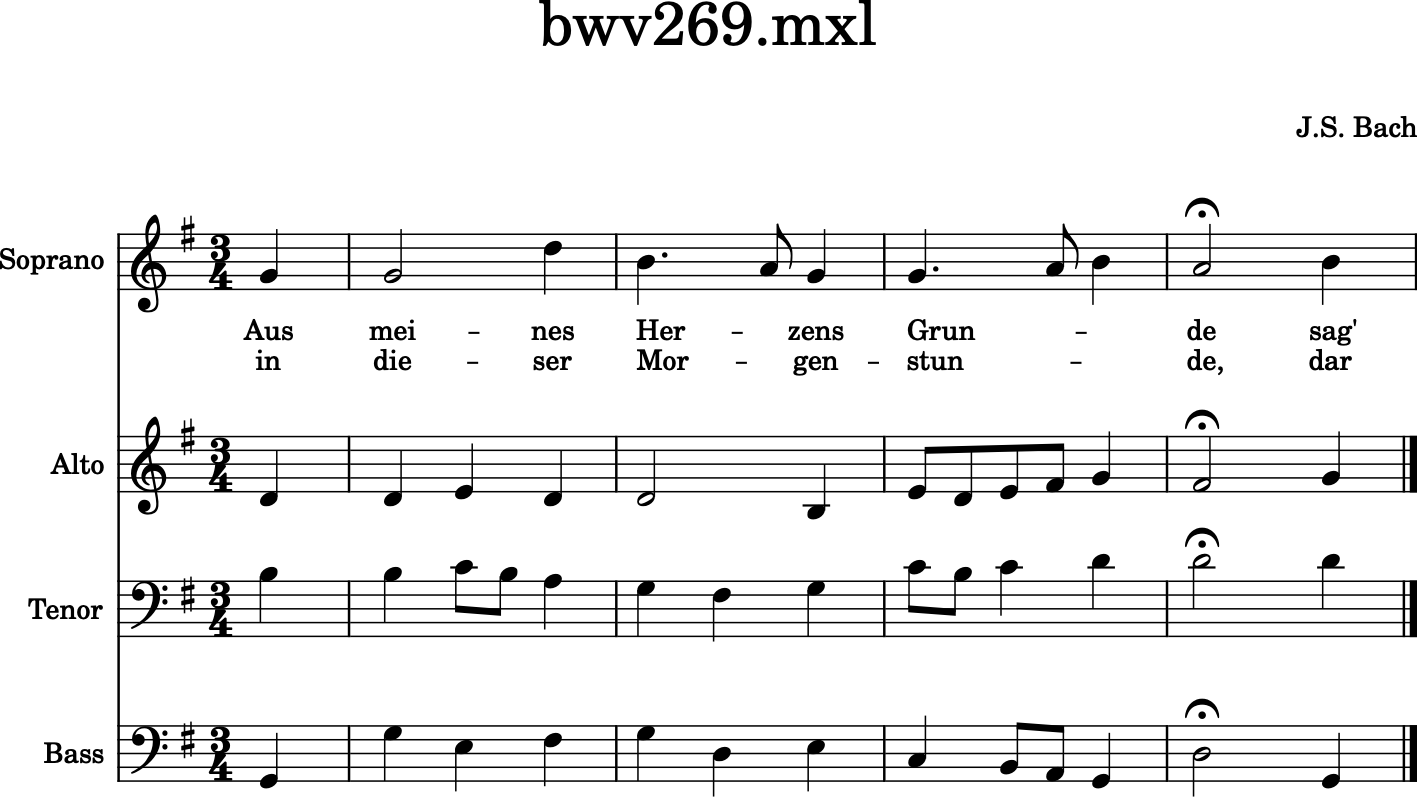

In [1]:
from music21 import *
bach = corpus.parse('bach/bwv269')
bach.id = 'bwv269'
bach.measures(0, 4).show()

We will start with most fully-functional of the various types of trees, the :class:`~music21.tree.timespanTree.TimespanTree`.  The `.asTimespans(flatten=True)` method on all Stream objects will get a tree of all timepoints in the piece: 

In [2]:
tsTree = bach.asTimespans(flatten=True)
tsTree

<TimespanTree {280} (0.0 to 63.0) <music21.stream.Score bwv269>>

The TimespanTree knows which score it came from, though at this point it is disconnected from the original stream.  It knows how many elements are in it (280) and what the flattened offset range of the tree is (from 0 to 63, or 21 measures of 3/4).

We can get the first element in the tree as expected:

In [3]:
tsTree[0]

<ElementTimespan (0.0 to 0.0) <music21.text.TextBox 'PDF © 2004...'>>

And iterate over the tree as you might expect:

In [4]:
for ts in tsTree[20:32]:
    print(ts)

<ElementTimespan (0.0 to 0.0) <music21.instrument.Instrument 'P4: Bass: '>>
<ElementTimespan (0.0 to 0.0) <music21.layout.SystemLayout>>
<ElementTimespan (0.0 to 0.0) <music21.layout.StaffLayout distance 130, staffNumber 1, staffSize None, staffLines None>>
<ElementTimespan (0.0 to 0.0) <music21.clef.BassClef>>
<ElementTimespan (0.0 to 0.0) <music21.key.Key of G major>>
<ElementTimespan (0.0 to 0.0) <music21.meter.TimeSignature 3/4>>
<ElementTimespan (0.0 to 0.0) <music21.layout.ScoreLayout>>
<ElementTimespan (0.0 to 0.0) <music21.layout.StaffGroup <music21.stream.Part Soprano><music21.stream.Part Alto><music21.stream.Part Tenor><music21.stream.Part Bass>>>
<PitchedTimespan (0.0 to 1.0) <music21.note.Note G>>
<PitchedTimespan (0.0 to 1.0) <music21.note.Note D>>
<PitchedTimespan (0.0 to 1.0) <music21.note.Note B>>
<PitchedTimespan (0.0 to 1.0) <music21.note.Note G>>


Notice that there are two types of "TimeSpans" in the tree, "PitchedTimespans" which contain anything that has one or more pitches, and "ElementTimespans" which have everything else.  The TimeSpans record their offsets from the beginning of the score and their "endTime".  Looking at measure 3 of the score makes this clearer.  I found these numbers via trial and error:

In [5]:
for ts in tsTree[55:71]:
    print(ts)

<PitchedTimespan (7.0 to 7.5) <music21.note.Note E>>
<PitchedTimespan (7.0 to 7.5) <music21.note.Note C>>
<PitchedTimespan (7.0 to 8.0) <music21.note.Note C>>
<PitchedTimespan (7.0 to 8.5) <music21.note.Note G>>
<PitchedTimespan (7.5 to 8.0) <music21.note.Note D>>
<PitchedTimespan (7.5 to 8.0) <music21.note.Note B>>
<PitchedTimespan (8.0 to 8.5) <music21.note.Note E>>
<PitchedTimespan (8.0 to 8.5) <music21.note.Note B>>
<PitchedTimespan (8.0 to 9.0) <music21.note.Note C>>
<PitchedTimespan (8.5 to 9.0) <music21.note.Note A>>
<PitchedTimespan (8.5 to 9.0) <music21.note.Note F#>>
<PitchedTimespan (8.5 to 9.0) <music21.note.Note A>>
<PitchedTimespan (9.0 to 10.0) <music21.note.Note B>>
<PitchedTimespan (9.0 to 10.0) <music21.note.Note G>>
<PitchedTimespan (9.0 to 10.0) <music21.note.Note D>>
<PitchedTimespan (9.0 to 10.0) <music21.note.Note G>>


Note that the notes here are not sorted in any particular order.  Reading from bottom to top at offset 7 would be "C C E G".  But this is not a concern because using indexes in a tree misses the point of them.

## So what *is* the point of a tree?

Trees let programmers find particular musical elements extremely fast.  So for instance, we can get all the elements starting at offset 7 with `elementsStartingAt`:

In [6]:
tsTree.elementsStartingAt(7.0)

(<PitchedTimespan (7.0 to 7.5) <music21.note.Note E>>,
 <PitchedTimespan (7.0 to 7.5) <music21.note.Note C>>,
 <PitchedTimespan (7.0 to 8.0) <music21.note.Note C>>,
 <PitchedTimespan (7.0 to 8.5) <music21.note.Note G>>)

And to get the actual notes in there, we use the `.element` property of the timespan:

In [7]:
[ts.element for ts in tsTree.elementsStartingAt(7.0)]

[<music21.note.Note E>,
 <music21.note.Note C>,
 <music21.note.Note C>,
 <music21.note.Note G>]

This is basically the same as `.getElementsByOffsetInHierarchy()`:

In [8]:
list(bach.recurse().notes.getElementsByOffsetInHierarchy(7.0))

[<music21.note.Note G>,
 <music21.note.Note E>,
 <music21.note.Note C>,
 <music21.note.Note C>]

But it is much faster, because the AVL tree can do a search for particular elements in `O(log n)` time.  It can even find elements ending at a certain point or overlapping a point just as fast:

In [9]:
tsTree.elementsOverlappingOffset(7.5)

(<PitchedTimespan (7.0 to 8.0) <music21.note.Note C>>,
 <PitchedTimespan (7.0 to 8.5) <music21.note.Note G>>)

In [10]:
tsTree.elementsStoppingAt(7.5)

(<PitchedTimespan (7.0 to 7.5) <music21.note.Note E>>,
 <PitchedTimespan (7.0 to 7.5) <music21.note.Note C>>)

A timespan tree knows all of its "timePoints" which are places where an element either stops or starts:

In [11]:
tsTree.allTimePoints()[:13]

(0.0, 1.0, 2.0, 2.5, 3.0, 4.0, 5.0, 5.5, 6.0, 7.0, 7.5, 8.0, 8.5)

Here are measures 3-4 alone to remind us of what is happening there:

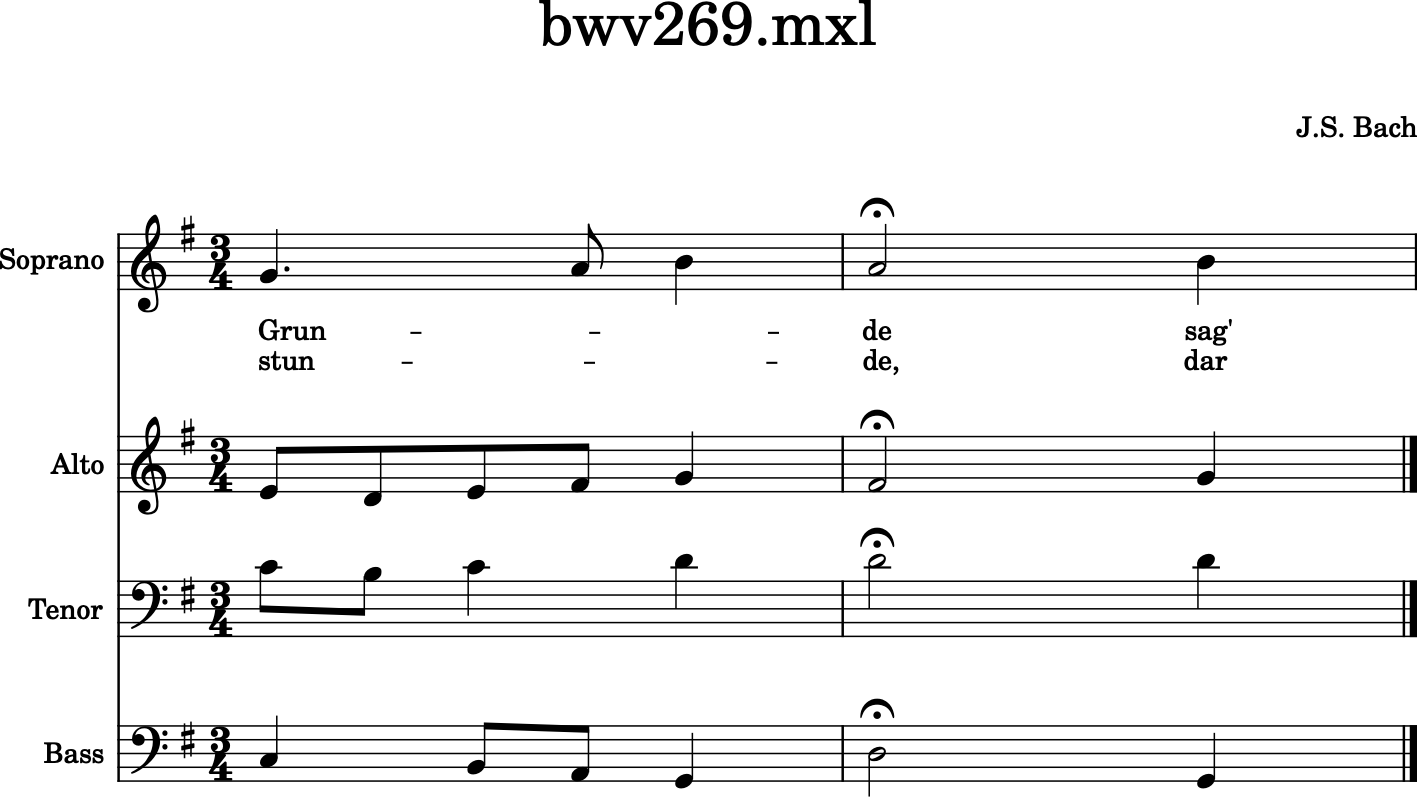

In [12]:
bach.measures(3, 4).show()

What is the chord sounding on beat 2 (offset 8)?  We can find out by creating a "Verticality" at this moment:

In [13]:
v = tsTree.getVerticalityAt(8.0)
v

<music21.tree.verticality.Verticality 8.0 {B2 C4 E4 G4}>

The Verticality object knows which elements are just starting:

In [14]:
v.startTimespans

(<PitchedTimespan (8.0 to 8.5) <music21.note.Note E>>,
 <PitchedTimespan (8.0 to 8.5) <music21.note.Note B>>,
 <PitchedTimespan (8.0 to 9.0) <music21.note.Note C>>)

and which are continuing:

In [15]:
v.overlapTimespans

(<PitchedTimespan (7.0 to 8.5) <music21.note.Note G>>,)

It also knows which elements are have just stopped before the Verticality:

In [16]:
v.stopTimespans

(<PitchedTimespan (7.0 to 8.0) <music21.note.Note C>>,
 <PitchedTimespan (7.5 to 8.0) <music21.note.Note D>>,
 <PitchedTimespan (7.5 to 8.0) <music21.note.Note B>>)

These timespans are not properly part of the verticality itself, so their pitches are not listed in the verticality itself.  Verticalities can also have non-pitched objects:

In [17]:
v_start = tsTree.getVerticalityAt(0)
v_start

<music21.tree.verticality.Verticality 0 {G2 B3 D4 G4}>

In [18]:
v_start.startTimespans[:10]

(<ElementTimespan (0.0 to 0.0) <music21.text.TextBox 'PDF © 2004...'>>,
 <ElementTimespan (0.0 to 0.0) <music21.text.TextBox 'BWV 269'>>,
 <ElementTimespan (0.0 to 0.0) <music21.metadata.Metadata object at 0x7f905dbaa250>>,
 <ElementTimespan (0.0 to 0.0) <music21.instrument.Instrument 'P1: Soprano: '>>,
 <ElementTimespan (0.0 to 0.0) <music21.layout.SystemLayout>>,
 <ElementTimespan (0.0 to 0.0) <music21.clef.TrebleClef>>,
 <ElementTimespan (0.0 to 0.0) <music21.key.Key of G major>>,
 <ElementTimespan (0.0 to 0.0) <music21.meter.TimeSignature 3/4>>,
 <ElementTimespan (0.0 to 0.0) <music21.instrument.Instrument 'P2: Alto: '>>,
 <ElementTimespan (0.0 to 0.0) <music21.layout.SystemLayout>>)

Verticalities with PitchedTimespans in them can figure out the bass timespan:

In [19]:
v.bassTimespan

<PitchedTimespan (8.0 to 8.5) <music21.note.Note B>>

They are also still connected to their original tree and know their offset:

In [20]:
v.timespanTree

<TimespanTree {280} (0.0 to 63.0) <music21.stream.Score bwv269>>

In [21]:
v.offset

8.0

And using this information they can get the verticalities just preceeding or following them:

In [22]:
(v.previousVerticality, v.nextVerticality)

(<music21.tree.verticality.Verticality 7.5 {C3 B3 D4 G4}>,
 <music21.tree.verticality.Verticality 8.5 {A2 C4 F#4 A4}>)

There is an easy way of getting all the pitches in a Verticality:

In [23]:
v.pitchSet

{<music21.pitch.Pitch B2>,
 <music21.pitch.Pitch C4>,
 <music21.pitch.Pitch E4>,
 <music21.pitch.Pitch G4>}

And a Verticality can become a chord:

In [24]:
v_ch = v.toChord()
v_ch

<music21.chord.Chord B2 C4 E4 G4>

This is a very dumb chord that just gets a default duration.  So even though the time between this verticality and the next one is only 0.5 (eighth note), the duration is still 1.0:

In [25]:
v_ch.duration

<music21.duration.Duration 1.0>

But, combined with the `.iterateVerticalities()` method on TimespanTrees, the `isChord()` method can make some quick analytical methods.  For instance, how many moments in this chorale are dissonant and how many are consonant?

In [26]:
totalConsonances = 0
totalDissonances = 0
for v in tsTree.iterateVerticalities():
    if v.toChord().isConsonant():
       totalConsonances += 1
    else:
       totalDissonances += 1
(totalConsonances, totalDissonances)

(48, 33)

So about 60% of the vertical moments are consonant, and 40% are dissonant.  But is this an
accurate perception? We can instead sum up the total consonant duration vs. dissonant duration using the `timeToNextEvent` property on Verticalities (new in v7.3):

In [27]:
totalConsonanceDuration = 0
totalDissonanceDuration = 0
for v in tsTree.iterateVerticalities():
    nextTime = v.timeToNextEvent
    if v.toChord().isConsonant():
       totalConsonanceDuration += nextTime
    else:
       totalDissonanceDuration += nextTime
(totalConsonanceDuration, totalDissonanceDuration)

(43.0, 20.0)

Only a little changed here, it's about a 2/3 to 1/3 proportion of consonance to dissonance, but it is nice to see that the total adds up to 63, the number of quarter notes in the piece, as we saw above.

Because Verticalities know the TimeSpans that stop just before the actual event, they are closely related to :class:`~music21.voiceLeading.VoiceLeadingQuartet` objects.  A verticality can find all the VoiceLeadingQuartets at that moment it begins.  We will first create a new tree that does not have anything but GeneralNote objects (otherwise Instrument objects and other such things can get in the way of finding voiceleading moments).

In [28]:
tsTree = bach.asTimespans(flatten=True, classList=(note.GeneralNote,))
v = tsTree.getVerticalityAt(2.0)
v

<music21.tree.verticality.Verticality 2.0 {E3 C4 E4 G4}>

In [29]:
v.getAllVoiceLeadingQuartets()

[<music21.voiceLeading.VoiceLeadingQuartet v1n1=B3, v1n2=C4, v2n1=D4, v2n2=E4>,
 <music21.voiceLeading.VoiceLeadingQuartet v1n1=B3, v1n2=C4, v2n1=G3, v2n2=E3>,
 <music21.voiceLeading.VoiceLeadingQuartet v1n1=B3, v1n2=C4, v2n1=G4, v2n2=G4>,
 <music21.voiceLeading.VoiceLeadingQuartet v1n1=D4, v1n2=E4, v2n1=G3, v2n2=E3>,
 <music21.voiceLeading.VoiceLeadingQuartet v1n1=D4, v1n2=E4, v2n1=G4, v2n2=G4>,
 <music21.voiceLeading.VoiceLeadingQuartet v1n1=G3, v1n2=E3, v2n1=G4, v2n2=G4>]

Reminding ourselves of the opening of the piece, this looks reasonable.  The voice-leading moment is between beats 1 and 2 of the first full measure.

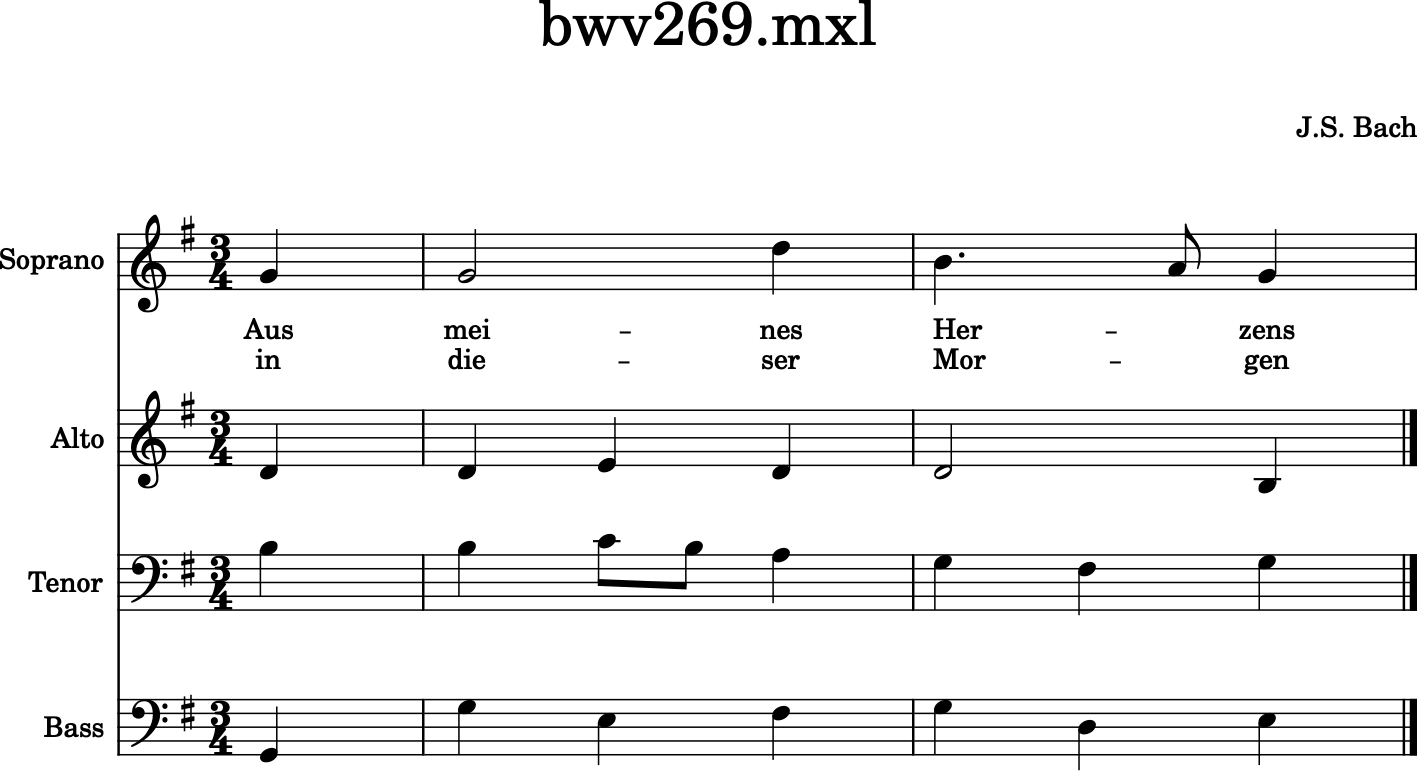

In [30]:
bach.measures(0, 2).show()

Note again that the order simultaneous elements are returned from a tree can seem a bit of voodoo.  Fortunately, it is possible still to get back what parts the various notes of the VoiceLeadingQuartet come from: 

In [31]:
all_vlqs = v.getAllVoiceLeadingQuartets()
vlq0 = all_vlqs[0]
print(vlq0.v1n1, vlq0.v1n1.getContextByClass('Part'))
print(vlq0.v2n1, vlq0.v2n1.getContextByClass('Part'))

<music21.note.Note B> <music21.stream.Part Tenor>
<music21.note.Note D> <music21.stream.Part Alto>


Verticalities can also find all the paired motions showing part by part:

In [32]:
v.getPairedMotion()

[(<PitchedTimespan (1.0 to 2.0) <music21.note.Note B>>,
  <PitchedTimespan (2.0 to 2.5) <music21.note.Note C>>),
 (<PitchedTimespan (1.0 to 2.0) <music21.note.Note D>>,
  <PitchedTimespan (2.0 to 3.0) <music21.note.Note E>>),
 (<PitchedTimespan (1.0 to 2.0) <music21.note.Note G>>,
  <PitchedTimespan (2.0 to 3.0) <music21.note.Note E>>),
 (<PitchedTimespan (1.0 to 3.0) <music21.note.Note G>>,
  <PitchedTimespan (1.0 to 3.0) <music21.note.Note G>>)]

There are also pre-filtering functions that prevent making more VoiceLeadingQuartets than are needed.  Let us move our attention to the verticality one beat back and look at the voiceleading motion from the end of the pickup measure to the first full measure, where only the bass moves (and that, only by octave).

In [33]:
v = tsTree.getVerticalityAt(1.0)
v

<music21.tree.verticality.Verticality 1.0 {G3 B3 D4 G4}>

By default, voice leading quartets representing no-motion are removed:

In [34]:
v.getAllVoiceLeadingQuartets()

[<music21.voiceLeading.VoiceLeadingQuartet v1n1=D4, v1n2=D4, v2n1=G2, v2n2=G3>,
 <music21.voiceLeading.VoiceLeadingQuartet v1n1=B3, v1n2=B3, v2n1=G2, v2n2=G3>,
 <music21.voiceLeading.VoiceLeadingQuartet v1n1=G2, v1n2=G3, v2n1=G4, v2n2=G4>]

they can be added back:

In [35]:
v.getAllVoiceLeadingQuartets(includeNoMotion=True)

[<music21.voiceLeading.VoiceLeadingQuartet v1n1=D4, v1n2=D4, v2n1=B3, v2n2=B3>,
 <music21.voiceLeading.VoiceLeadingQuartet v1n1=D4, v1n2=D4, v2n1=G2, v2n2=G3>,
 <music21.voiceLeading.VoiceLeadingQuartet v1n1=D4, v1n2=D4, v2n1=G4, v2n2=G4>,
 <music21.voiceLeading.VoiceLeadingQuartet v1n1=B3, v1n2=B3, v2n1=G2, v2n2=G3>,
 <music21.voiceLeading.VoiceLeadingQuartet v1n1=B3, v1n2=B3, v2n1=G4, v2n2=G4>,
 <music21.voiceLeading.VoiceLeadingQuartet v1n1=G2, v1n2=G3, v2n1=G4, v2n2=G4>]

or we can filter further and remove oblique motion as well, which will remove all VoiceLeadingQuartets here:

In [36]:
v.getAllVoiceLeadingQuartets(includeOblique=False)

[]

## TimeSpans vs Music21Objects

TimeSpans (including PitchedTimeSpans) are not Music21Objects, so they cannot be put into Streams.  Rather, they are wrappers around elements already in the Stream, such as Notes, Clefs, etc.  When the TimespanTree is first created, each element is in exactly one TimeSpan, but that can change.  Here we will grab a PitchedTimeSpan from measure 2 and then divide it into two halves:

In [60]:
fs_span = tsTree[20]
fs_span

<PitchedTimespan (5.0 to 6.0) <music21.note.Note F#>>

In [61]:
fs_span.splitAt(5.5)

(<PitchedTimespan (5.0 to 5.5) <music21.note.Note F#>>,
 <PitchedTimespan (5.5 to 6.0) <music21.note.Note F#>>)

The timespan itself is unchanged:

In [62]:
fs_span

<PitchedTimespan (5.0 to 6.0) <music21.note.Note F#>>

So we will split again and show that the element is the same in both:

In [63]:
first_half, second_half = fs_span.splitAt(5.5)
first_half.element

<music21.note.Note F#>

In [64]:
first_half.element is second_half.element

True

Splitting the TimeSpan does *not* change the duration of the element:

In [65]:
first_half.element.duration

<music21.duration.Duration 1.0>

There is a reason for this complexity (and you were warned that trees were a complex topic).  Updating a duration of a Music21Object takes a good amount of processing time: the type or tuplets need to change, their containing Streams update their own durations, and so on.  By manipulating the TimeSpan's lengths separately from the object, many changes to a representation of the score can be done before the final output is created.

However, a TimeSpan can create an object with the duration of the TimeSpan:

In [66]:
new_fs = first_half.makeElement()
new_fs

<music21.note.Note F#>

In [67]:
new_fs.duration.quarterLength

0.5

However, the new object is not the same as the old object, but is instead a copy:

In [68]:
new_fs is fs_span.element

False

In [69]:
new_fs.derivation.origin is fs_span.element

True

If you want to modify the element in place, call `makeElement(makeCopy=False)`.

Note that when iterating verticalities, the same TimeSpans may appear in multiple verticalities, once in the .startTimespans, zero, one, or more times in the .overlapTimeSpans, and once in the .stopTimespans.  And the verticality's distance to the next verticality is not necessarily the same as any TimeSpan's duration.  As in this example:

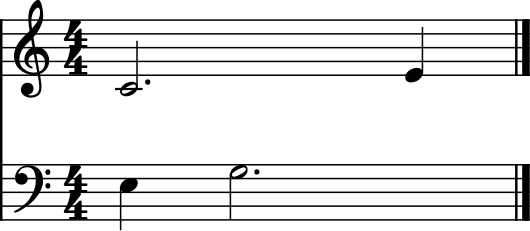

In [70]:
p1 = converter.parse('tinyNotation: 4/4 c2. e4')
p2 = converter.parse('tinyNotation: 4/4 E4 G2.')
sc = stream.Score([p1, p2])
sc.show()

In [71]:
from pprint import pprint
for vert in sc.asTimespans(flatten=True, classList=(note.Note,)).iterateVerticalities():
    pprint([vert.timeToNextEvent, vert.stopTimespans, vert.startTimespans, vert.overlapTimespans])

[1.0,
 (),
 (<PitchedTimespan (0.0 to 1.0) <music21.note.Note E>>,
  <PitchedTimespan (0.0 to 3.0) <music21.note.Note C>>),
 ()]
[2.0,
 (<PitchedTimespan (0.0 to 1.0) <music21.note.Note E>>,),
 (<PitchedTimespan (1.0 to 4.0) <music21.note.Note G>>,),
 (<PitchedTimespan (0.0 to 3.0) <music21.note.Note C>>,)]
[1.0,
 (<PitchedTimespan (0.0 to 3.0) <music21.note.Note C>>,),
 (<PitchedTimespan (3.0 to 4.0) <music21.note.Note E>>,),
 (<PitchedTimespan (1.0 to 4.0) <music21.note.Note G>>,)]


The second Verticality has two quarter notes until the next one, but none of the TimeSpans involved in it, nor their contained elements, have a duration of 2.0.

One last thing for now to mention about durations and timing of TimeSpans, is that they are always floats even if they contain tuplets which usually have Fractional elements:

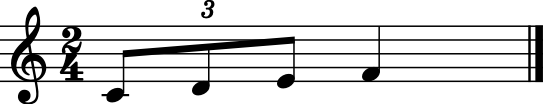

In [72]:
triplet_score = converter.parse('tinyNotation: 2/4 trip{c8 d e} f4')
triplet_score.id = 'triplet_score'
triplet_score.show()

In [73]:
triplet_tree = triplet_score.asTimespans(flatten=True, classList=(note.Note,))
triplet_tree

<TimespanTree {4} (0.0 to 2.0) <music21.stream.Part triplet_score>>

In [74]:
for vert in triplet_tree.iterateVerticalities():
    print('---')
    print(vert)
    print(vert.offset)
    print(vert.startTimespans)

---
<music21.tree.verticality.Verticality 0.0 {C4}>
0.0
(<PitchedTimespan (0.0 to 0.3333333333333333) <music21.note.Note C>>,)
---
<music21.tree.verticality.Verticality 0.3333333333333333 {D4}>
0.3333333333333333
(<PitchedTimespan (0.3333333333333333 to 0.6666666666666666) <music21.note.Note D>>,)
---
<music21.tree.verticality.Verticality 0.6666666666666666 {E4}>
0.6666666666666666
(<PitchedTimespan (0.6666666666666666 to 1.0) <music21.note.Note E>>,)
---
<music21.tree.verticality.Verticality 1.0 {F4}>
1.0
(<PitchedTimespan (1.0 to 2.0) <music21.note.Note F>>,)


We do this with trees because it allows much faster manipulations, and it is an advanced feature for people who are willing to use :func:`music21.common.numberTools.opFrac` on outputs or math.isclose() to compare:

In [75]:
for vert in triplet_tree.iterateVerticalities():
    print(repr(common.opFrac(vert.offset)))

0.0
Fraction(1, 3)
Fraction(2, 3)
1.0


In [76]:
triplet_tree.getVerticalityAt(1/3)

<music21.tree.verticality.Verticality 0.3333333333333333 {D4}>

## `makeElement`: the guts of Chordify

Verticalities have a better way of making elements than toChord, and that is :meth:`~music21.tree.verticality.Verticality.makeElement()`.  The makeElement method will return rests where there is nothing playing, and will do things like make sure that only one copy of any articulation or expression class is appended to the element (and only if the element is in the right place to take the articulation).  It will also intelligently add ties if you are making an element which extends into the next chord, and by default will remove redundant pitches and make copies of elements.

If it sounds like you will never use something like that, because you have :meth:`~music21.stream.base.Stream.chordify()`, you're absolutely right!  Trees, Verticalities, and makeElement are what powers chordify.  So you would only use `makeElement` individually if you wanted to perform manipulations on the Stream before chordifying, such as to remove passing tones or notes that are shorter than a certain length.

We will return to using TimespanTrees to make reductions in the next chapter (to be written).